## Testing a metric to calculate the effect of crowding on color ##

With the metrics in this notebook, we want to use Rubin LSST simulations to answer two questions:
- Given magnitudes in two bands, what is the error in measurement of the color at a given point on the sky?
- Given a limit on the error in the color, how deep will a given point on the sky get in two bands?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import os
import healpy as hp
from scipy.interpolate import griddata, interp1d, interpn
from scipy.interpolate import RectBivariateSpline
# Import MAF
import rubin_sim.maf as maf

%matplotlib inline   
# %matplotlib notebook

In [2]:
# import color crowding metric routines
from colorCrowding import *

This metric makes use of joint luminosity functions calculated with Leo Girardi's TRILEGAL simulation.  These LFs give the number of stars per healpix (NSIDE=64) in bins of magnitudes in two bands.  Below we read in an example LF and aggreagate the table to show the map of total number of stars.

In [3]:
# Test loading the joint LF and plotting it
nside = 32
lfpath = './'
t = Table.read(lfpath+'jointlf_gi_rd32_wVecs.fits')
tg = t.group_by('ring'+str(nside))
ts = tg.groups.aggregate(np.sum)
map = np.zeros(hp.nside2npix(nside))
map[ts['ring'+str(nside)]] = ts['n']

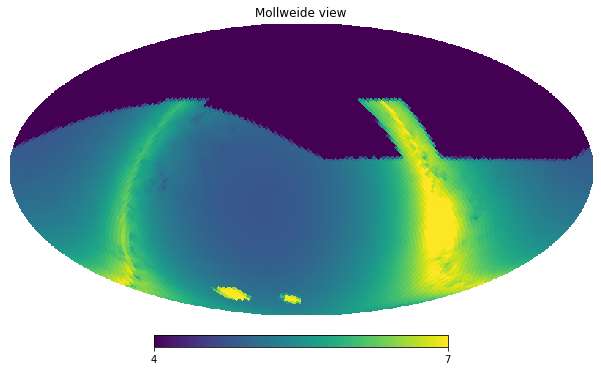

In [4]:
hp.mollview(np.log10(map+1),min=4,max=7)

You need to connect to the opsim output, so let's do that first. <br>
It's easy to use the current baseline simulation included with $RUBIN_SIM_DATA_DIR, so let's start with that.

In [5]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/sims_maf/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


In [6]:
# Connect to the database so we can use it with MAF.
opsim_db = maf.OpsimDatabase(opsim_fname)

Now set up to work with our Metric. Remember that the Metric will work on a single DataSlice at a time -- so 
*all* of (and *only*) the observation information it receives will be the visits relevant to this test_ra/test_dec location.

This metric builds on the existing single-band CrowdingMagUncertMetric.

In [7]:
slicer = maf.HealpixSlicer(nside=32)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


The typical way to use this metric with a slicer within MAF would be as follows: 

In [8]:
# Set up the metric
metric = CrowdingMagColorUncertMetric()
#metric = CrowdingColorM5Metric()

In [9]:
metric.name

'CrowdingMagColorUncertMetric at g = 20.00 r = 20.00'

In [10]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = '(filter = "g" or filter = "r")'   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [11]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(metric, slicer, sqlconstraint, runName=runName)

In [12]:
%%time
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_db, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying database observations with constraint (filter = "g" or filter = "r") for columns ['rotSkyPos', 'seeingFwhmGeom', 'fieldDec', 'fieldRA', 'filter']
Found 682668 visits
Running:  ['test_metric']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 6min 41s, sys: 3.18 s, total: 6min 44s
Wall time: 6min 46s


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
0.0 180.0 -180.0 180.0


Plotting figures with "(filter = "g" or filter = "r")" constraint now.


0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 284 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 233 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


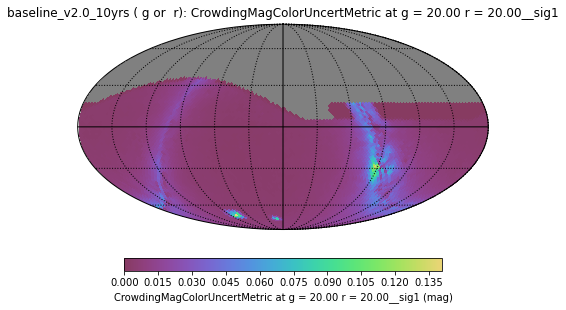

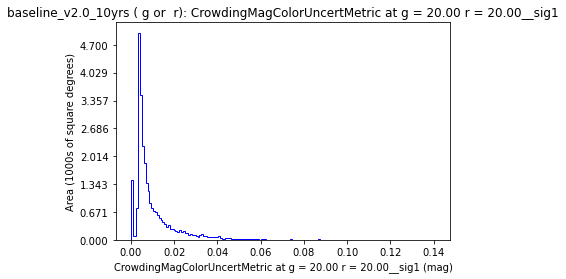

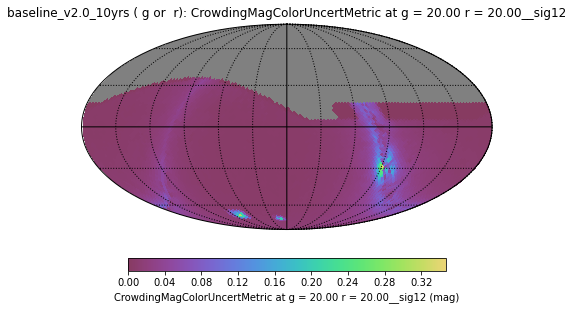

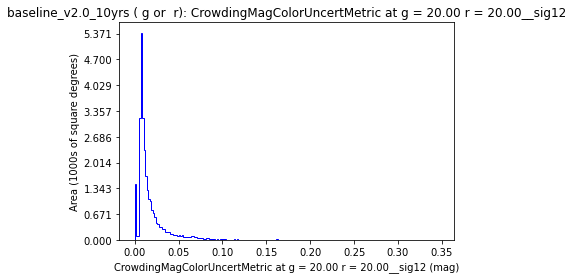

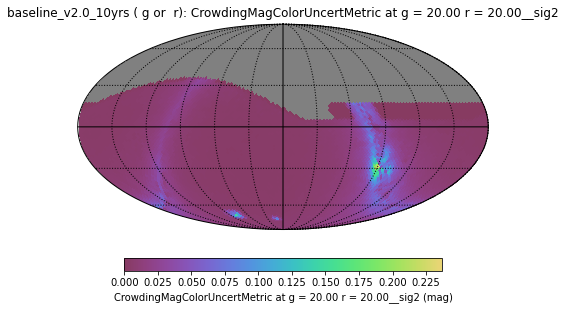

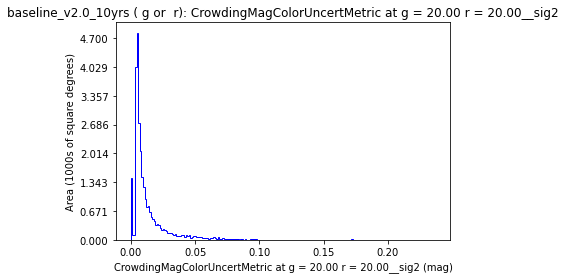

In [13]:
g.plotAll(closefigs=False)

As seen from the plot of sig12 (in this case error in g-r) compared to sig1 (error in g) and sig2 (error in r), the color error due to crowding is typically less than sqrt(sig1^2 + sig2^2).

And then you can look at the `bundle.metricValues` to see what your metric calculated and how well things worked.

In [14]:
bundle.metricValues

masked_array(data=[--, --, --, ...,
                   {'sig1': array(0.01206921), 'sig2': array(0.01449697), 'sig12': array([0.02034032])},
                   {'sig1': array(0.01305847), 'sig2': array(0.01558414), 'sig12': array([0.02160099])},
                   {'sig1': array(0.00978536), 'sig2': array(0.01159198), 'sig12': array([0.01635176])}],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30,
            dtype=object)

Now we'll look at the crowding depth metric, which computes the magnitude at which the error in color due to crowding is less than a set value.

In [15]:
# Set up the crowding depth metric
metric = CrowdingColorM5Metric()

In [16]:
metric.name

'CrowdingColorM5Metric at error < 0.10 at g - r = 0.00'

In [17]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = '(filter = "g" or filter = "r")'   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [18]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(metric, slicer, sqlconstraint, runName=runName)

In [19]:
%%time
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_db, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying database observations with constraint (filter = "g" or filter = "r") for columns ['rotSkyPos', 'seeingFwhmGeom', 'fieldDec', 'fieldRA', 'filter']
Found 682668 visits
Running:  ['test_metric']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 7min 7s, sys: 3.53 s, total: 7min 10s
Wall time: 7min 12s


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
0.0 180.0 -180.0 180.0


Plotting figures with "(filter = "g" or filter = "r")" constraint now.


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


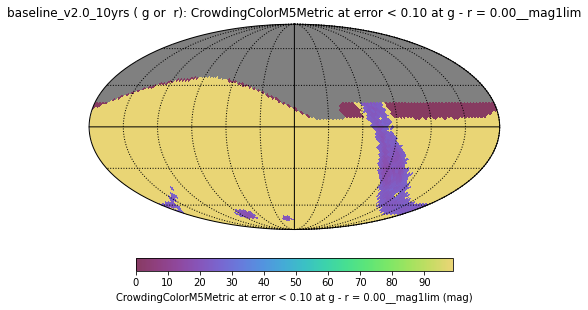

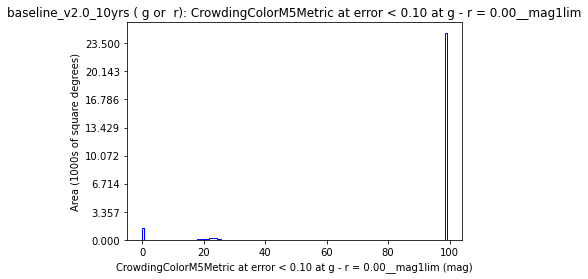

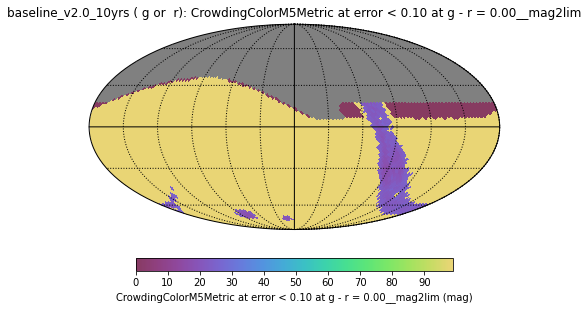

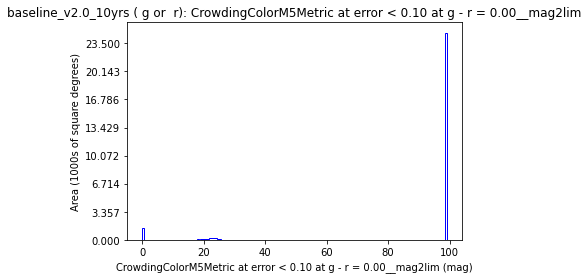

In [20]:
g.plotAll(closefigs=False)